In [7]:
%matplotlib inline
import torch
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
import torch.optim as optim
import optuna
import random
import itertools
from itertools import permutations
torch.set_printoptions(edgeitems=2, linewidth=75)

In [8]:
def rotation_matrix(n, theta):
    """
    Compute the Rodrigues rotation matrix for a given axis n and angle theta.

    Parameters:
        n (torch.Tensor): Rotation axis (normalized).
        theta (float): Rotation angle in radian.

    Returns:
        - (torch.Tensor) -- 3x3 rotation matrix.
    """
    K = torch.tensor([[0.0, -n[2], n[1]], 
                      [n[2], 0.0, -n[0]], 
                      [-n[1], n[0], 0.0]])
    I = torch.eye(3)
    R = I + torch.sin(theta) * K + (1.0 - torch.cos(theta)) * torch.mm(K, K)
    return R

def cross_product(v1, v2):
    return torch.cross(v1, v2, dim=0)

def magnetic(axis, vec, theta):
    cos_theta = torch.cos(theta)
    sin_theta = torch.sin(theta)
    
    axis = axis.unsqueeze(0)  # (1, 3)
    vec = vec.unsqueeze(0)    # (1, 3)
    
    rotated_vecs = []
    for i in range(theta.size(0)):
        theta_i = theta[i]
        cos_theta_i = cos_theta[i]
        sin_theta_i = sin_theta[i]
        
        axis_i = axis[0]
        vec_i = vec[0]
        
        rotated_vec = vec_i * cos_theta_i + cross_product(axis_i, vec_i) * sin_theta_i + axis_i * (torch.matmul(axis_i.unsqueeze(1).T, vec_i.unsqueeze(1)).squeeze() * (1 - cos_theta_i))
        rotated_vecs.append(rotated_vec)
    
    return torch.stack(rotated_vecs)

def model(x, k1, k2, k3, k4, k5, k6, t1, p1, t2, p2):
    rad = torch.pi / 180.0  # Conversion factor from degrees to radians
    nx = torch.cos(p1 * rad) * torch.sin(t1 * rad)
    ny = torch.sin(p1 * rad) * torch.sin(t1 * rad)
    nz = torch.cos(t1 * rad)
    sx = torch.cos(p2 * rad) * torch.sin(t2 * rad)
    sy = torch.sin(p2 * rad) * torch.sin(t2 * rad)
    sz = torch.cos(t2 * rad)
    theta = x * rad

    # Define matrices
    E = torch.eye(3)
    C3 = rotation_matrix(torch.tensor([0.0, 0.0, 1.0]), torch.tensor([2.0 * torch.pi / 3.0])) # for Te2.
    C3i = C3.T # for Te3.
    Rs = [E, C3i, C3]
    
    h = magnetic(torch.stack([nx, ny, nz]), torch.stack([sx, sy, sz]), theta)
    ht = magnetic(cross_product(torch.stack([nx, ny, nz]), torch.stack([sx, sy, sz])), torch.tensor([sx, sy, sz]), theta)
    k = torch.stack([
    torch.stack([k1, k6, k5]),
    torch.stack([k6, k2, k4]),
    torch.stack([k5, k4, k3])
    ])
    Ks = [torch.einsum('ik,kl,jl->ij', R, k, R) for R in Rs]
    shift1 = [torch.einsum('ij,jk,ik->i', h, K, h) for K in Ks]
    shift2 = [torch.einsum('ij,jk,ik->i', ht, K, ht) for K in Ks]
    
    return {'shift1': torch.stack(shift1), 'shift2': torch.stack(shift2)}

In [9]:
# 各CSVファイルの読み込み
csv_files1 = ['xy(1) copy.csv', 'xy(2) copy.csv', 'xy(3) copy.csv']
df1 = [pd.read_csv(f) for f in csv_files1]

csv_files2 = ['xy1 copy.csv', 'xy2 copy.csv', 'xy3 copy.csv']
df2 = [pd.read_csv(f) for f in csv_files2]

dfs = [df1, df2]

# データの抽出
x_values = []
y_values = []

for df_group in dfs:
    for i in range(len(df_group)):
        x_values.append(df_group[i]['x'].values)
        y_values.append(df_group[i]['y'].values)

# リストの全てのデータをtorch.tensorに変換
x_tensors = []
y_tensors = []

for x, y in zip(x_values, y_values):
    x_tensors.append(torch.tensor(x, dtype=torch.float32, requires_grad=True))
    y_tensors.append(torch.tensor(y, dtype=torch.float32))

# 結果を個別に代入（必要なら）
x1, x2, x3, x4, x5, x6 = x_tensors
y1, y2, y3, y4, y5, y6 = y_tensors

In [10]:
def loss_fn(y_p, y):
    squared_diffs = (y_p - y)**2
    return squared_diffs.mean()

In [11]:
def combined_loss_fn(y_p1, y1, y_p2, y2, y_p3, y3, y_p4, y4, y_p5, y5, y_p6, y6):
    loss1 = loss_fn(y_p1, y1)
    loss2 = loss_fn(y_p2, y2)
    loss3 = loss_fn(y_p3, y3)
    loss4 = loss_fn(y_p4, y4)
    loss5 = loss_fn(y_p5, y5)
    loss6 = loss_fn(y_p6, y6)

    total_loss = loss1 + loss2 + loss3 + loss4 + loss5 + loss6
    return total_loss

In [12]:
# 最適化のためのobjective関数
def objective(trial):
    # パラメータをsuggestする
    k1 = torch.tensor(trial.suggest_float('k1', -10.0, 10.0), dtype=torch.float32, requires_grad=True)
    k2 = torch.tensor(trial.suggest_float('k2', -10.0, 10.0), dtype=torch.float32, requires_grad=True)
    k3 = torch.tensor(trial.suggest_float('k3', -10.0, 10.0), dtype=torch.float32, requires_grad=True)
    k4 = torch.tensor(trial.suggest_float('k4', -10.0, 10.0), dtype=torch.float32, requires_grad=True)
    k5 = torch.tensor(trial.suggest_float('k5', -10.0, 10.0), dtype=torch.float32, requires_grad=True)
    k6 = torch.tensor(trial.suggest_float('k6', -10.0, 10.0), dtype=torch.float32, requires_grad=True)
    t1 = torch.tensor(trial.suggest_float('t1', 0.0, 90.0), dtype=torch.float32, requires_grad=True)
    p1 = torch.tensor(trial.suggest_float('p1', 0.0, 90.0), dtype=torch.float32, requires_grad=True)
    t2 = torch.tensor(trial.suggest_float('t2', 0.0, 90.0), dtype=torch.float32, requires_grad=True)
    p2 = torch.tensor(trial.suggest_float('p2', 0.0, 90.0), dtype=torch.float32, requires_grad=True)

    # モデルにこれらのパラメータを使用
    outputs = [model(x, k1, k2, k3, k4, k5, k6, t1, p1, t2, p2) for x in [x1, x2, x3, x4, x5, x6]]

    y_p1 = outputs[0]['shift1'][0]
    y_p2 = outputs[1]['shift1'][1]
    y_p3 = outputs[2]['shift1'][2]
    y_p4 = outputs[3]['shift2'][0]
    y_p5 = outputs[4]['shift2'][1]
    y_p6 = outputs[5]['shift2'][2]

    # ロス計算
    loss = combined_loss_fn(y_p1, y1, y_p2, y2, y_p3, y3, y_p4, y4, y_p5, y5, y_p6, y6)
    
    return loss.item()

# 最適なパラメータを見つけるためのループ
best_epoch0_loss = float('inf')
best_params = None

for _ in range(10):
    # Optunaで最適化
    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=100)

    # epoch0のLossが最小のパラメータを保持
    if study.best_value < best_epoch0_loss:
        best_epoch0_loss = study.best_value
        best_params = study.best_params

# 最適なパラメータでのトレーニング
if best_params is not None:
    k1 = torch.nn.Parameter(torch.tensor(best_params['k1']))
    k2 = torch.nn.Parameter(torch.tensor(best_params['k2']))
    k3 = torch.nn.Parameter(torch.tensor(best_params['k3']))
    k4 = torch.nn.Parameter(torch.tensor(best_params['k4']))
    k5 = torch.nn.Parameter(torch.tensor(best_params['k5']))
    k6 = torch.nn.Parameter(torch.tensor(best_params['k6']))
    t1 = torch.nn.Parameter(torch.tensor(best_params['t1']))
    p1 = torch.nn.Parameter(torch.tensor(best_params['p1']))
    t2 = torch.nn.Parameter(torch.tensor(best_params['t2']))
    p2 = torch.nn.Parameter(torch.tensor(best_params['p2']))

    optimizer = optim.Adam([k1, k2, k3, k4, k5, k6, t1, p1, t2, p2], lr=1e-2)

    prev_loss = float('inf')

    for epoch in range(10000):
        optimizer.zero_grad()

        outputs = [model(x, k1, k2, k3, k4, k5, k6, t1, p1, t2, p2) for x in [x1, x2, x3, x4, x5, x6]]

        y_p1 = outputs[0]['shift1'][0]
        y_p2 = outputs[1]['shift1'][1]
        y_p3 = outputs[2]['shift1'][2]
        y_p4 = outputs[3]['shift2'][0]
        y_p5 = outputs[4]['shift2'][1]
        y_p6 = outputs[5]['shift2'][2]

        loss = combined_loss_fn(y_p1, y1, y_p2, y2, y_p3, y3, y_p4, y4, y_p5, y5, y_p6, y6)

        if epoch == 0:
            epoch0_loss = loss.item()
            if epoch0_loss >= 35:
                print(f"Epoch 0 Loss is {epoch0_loss}, which is >= 35. Stopping training.")
                break

        if loss.item() > prev_loss:
            print(f"Loss increased at epoch {epoch}. Stopping training.")
            break

        prev_loss = loss.item()
        loss.backward()
        optimizer.step()

        # パラメータのクランプ
        with torch.no_grad():
            # Clamp the first 6 parameters to be within [-10, 10]
            for param in [k1, k2, k3, k4, k5, k6]:
                param.data = torch.clamp(param.data, -10.0, 10.0)
        
            # Clamp the remaining 4 parameters to be within [0, 90]
            for param in [t1, p1, t2, p2]:
                param.data = torch.clamp(param.data, 0.0, 90.0)

        if epoch % 100 == 0:
            print(f'Epoch {epoch}, Loss: {loss.item()}')

[I 2024-09-12 17:51:21,470] A new study created in memory with name: no-name-501f20f1-ed35-40a3-a456-1368432906df
[I 2024-09-12 17:51:21,499] Trial 0 finished with value: 511.5719299316406 and parameters: {'k1': -9.757247168189114, 'k2': 5.6859674704909935, 'k3': 5.370166428021985, 'k4': 7.258336429452957, 'k5': 6.773848172679848, 'k6': -1.5116996955475521, 't1': 72.10696895111965, 'p1': 64.47548675350653, 't2': 62.408331472998675, 'p2': 88.17940773756828}. Best is trial 0 with value: 511.5719299316406.
[I 2024-09-12 17:51:21,522] Trial 1 finished with value: 438.6577453613281 and parameters: {'k1': 2.2769778255079522, 'k2': 8.910372254514836, 'k3': 1.879384803954549, 'k4': -4.241067159348031, 'k5': -2.5517720548494705, 'k6': 6.433840057347908, 't1': 80.17295958649558, 'p1': 32.767078421355734, 't2': 75.08794293737363, 'p2': 31.12601844759193}. Best is trial 1 with value: 438.6577453613281.
[I 2024-09-12 17:51:21,547] Trial 2 finished with value: 245.61337280273438 and parameters: {'k1

Epoch 0, Loss: 22.848430633544922
Epoch 100, Loss: 15.093920707702637
Epoch 200, Loss: 11.625046730041504
Epoch 300, Loss: 9.693248748779297
Epoch 400, Loss: 8.509466171264648
Epoch 500, Loss: 7.772085189819336
Epoch 600, Loss: 7.326629638671875
Epoch 700, Loss: 7.03767204284668
Epoch 800, Loss: 6.813387393951416
Epoch 900, Loss: 6.601720809936523
Epoch 1000, Loss: 6.362675666809082
Epoch 1100, Loss: 6.097774982452393
Epoch 1200, Loss: 5.820742130279541
Epoch 1300, Loss: 5.540316581726074
Epoch 1400, Loss: 5.259981632232666
Epoch 1500, Loss: 4.980757236480713
Epoch 1600, Loss: 4.521628379821777
Epoch 1700, Loss: 4.11237907409668
Epoch 1800, Loss: 3.7475717067718506
Epoch 1900, Loss: 3.449122667312622
Epoch 2000, Loss: 3.1876375675201416
Epoch 2100, Loss: 2.9488017559051514
Epoch 2200, Loss: 2.724811315536499
Epoch 2300, Loss: 2.5114896297454834
Epoch 2400, Loss: 2.3068456649780273
Epoch 2500, Loss: 2.110183000564575
Epoch 2600, Loss: 1.9215415716171265
Epoch 2700, Loss: 1.7413359880447

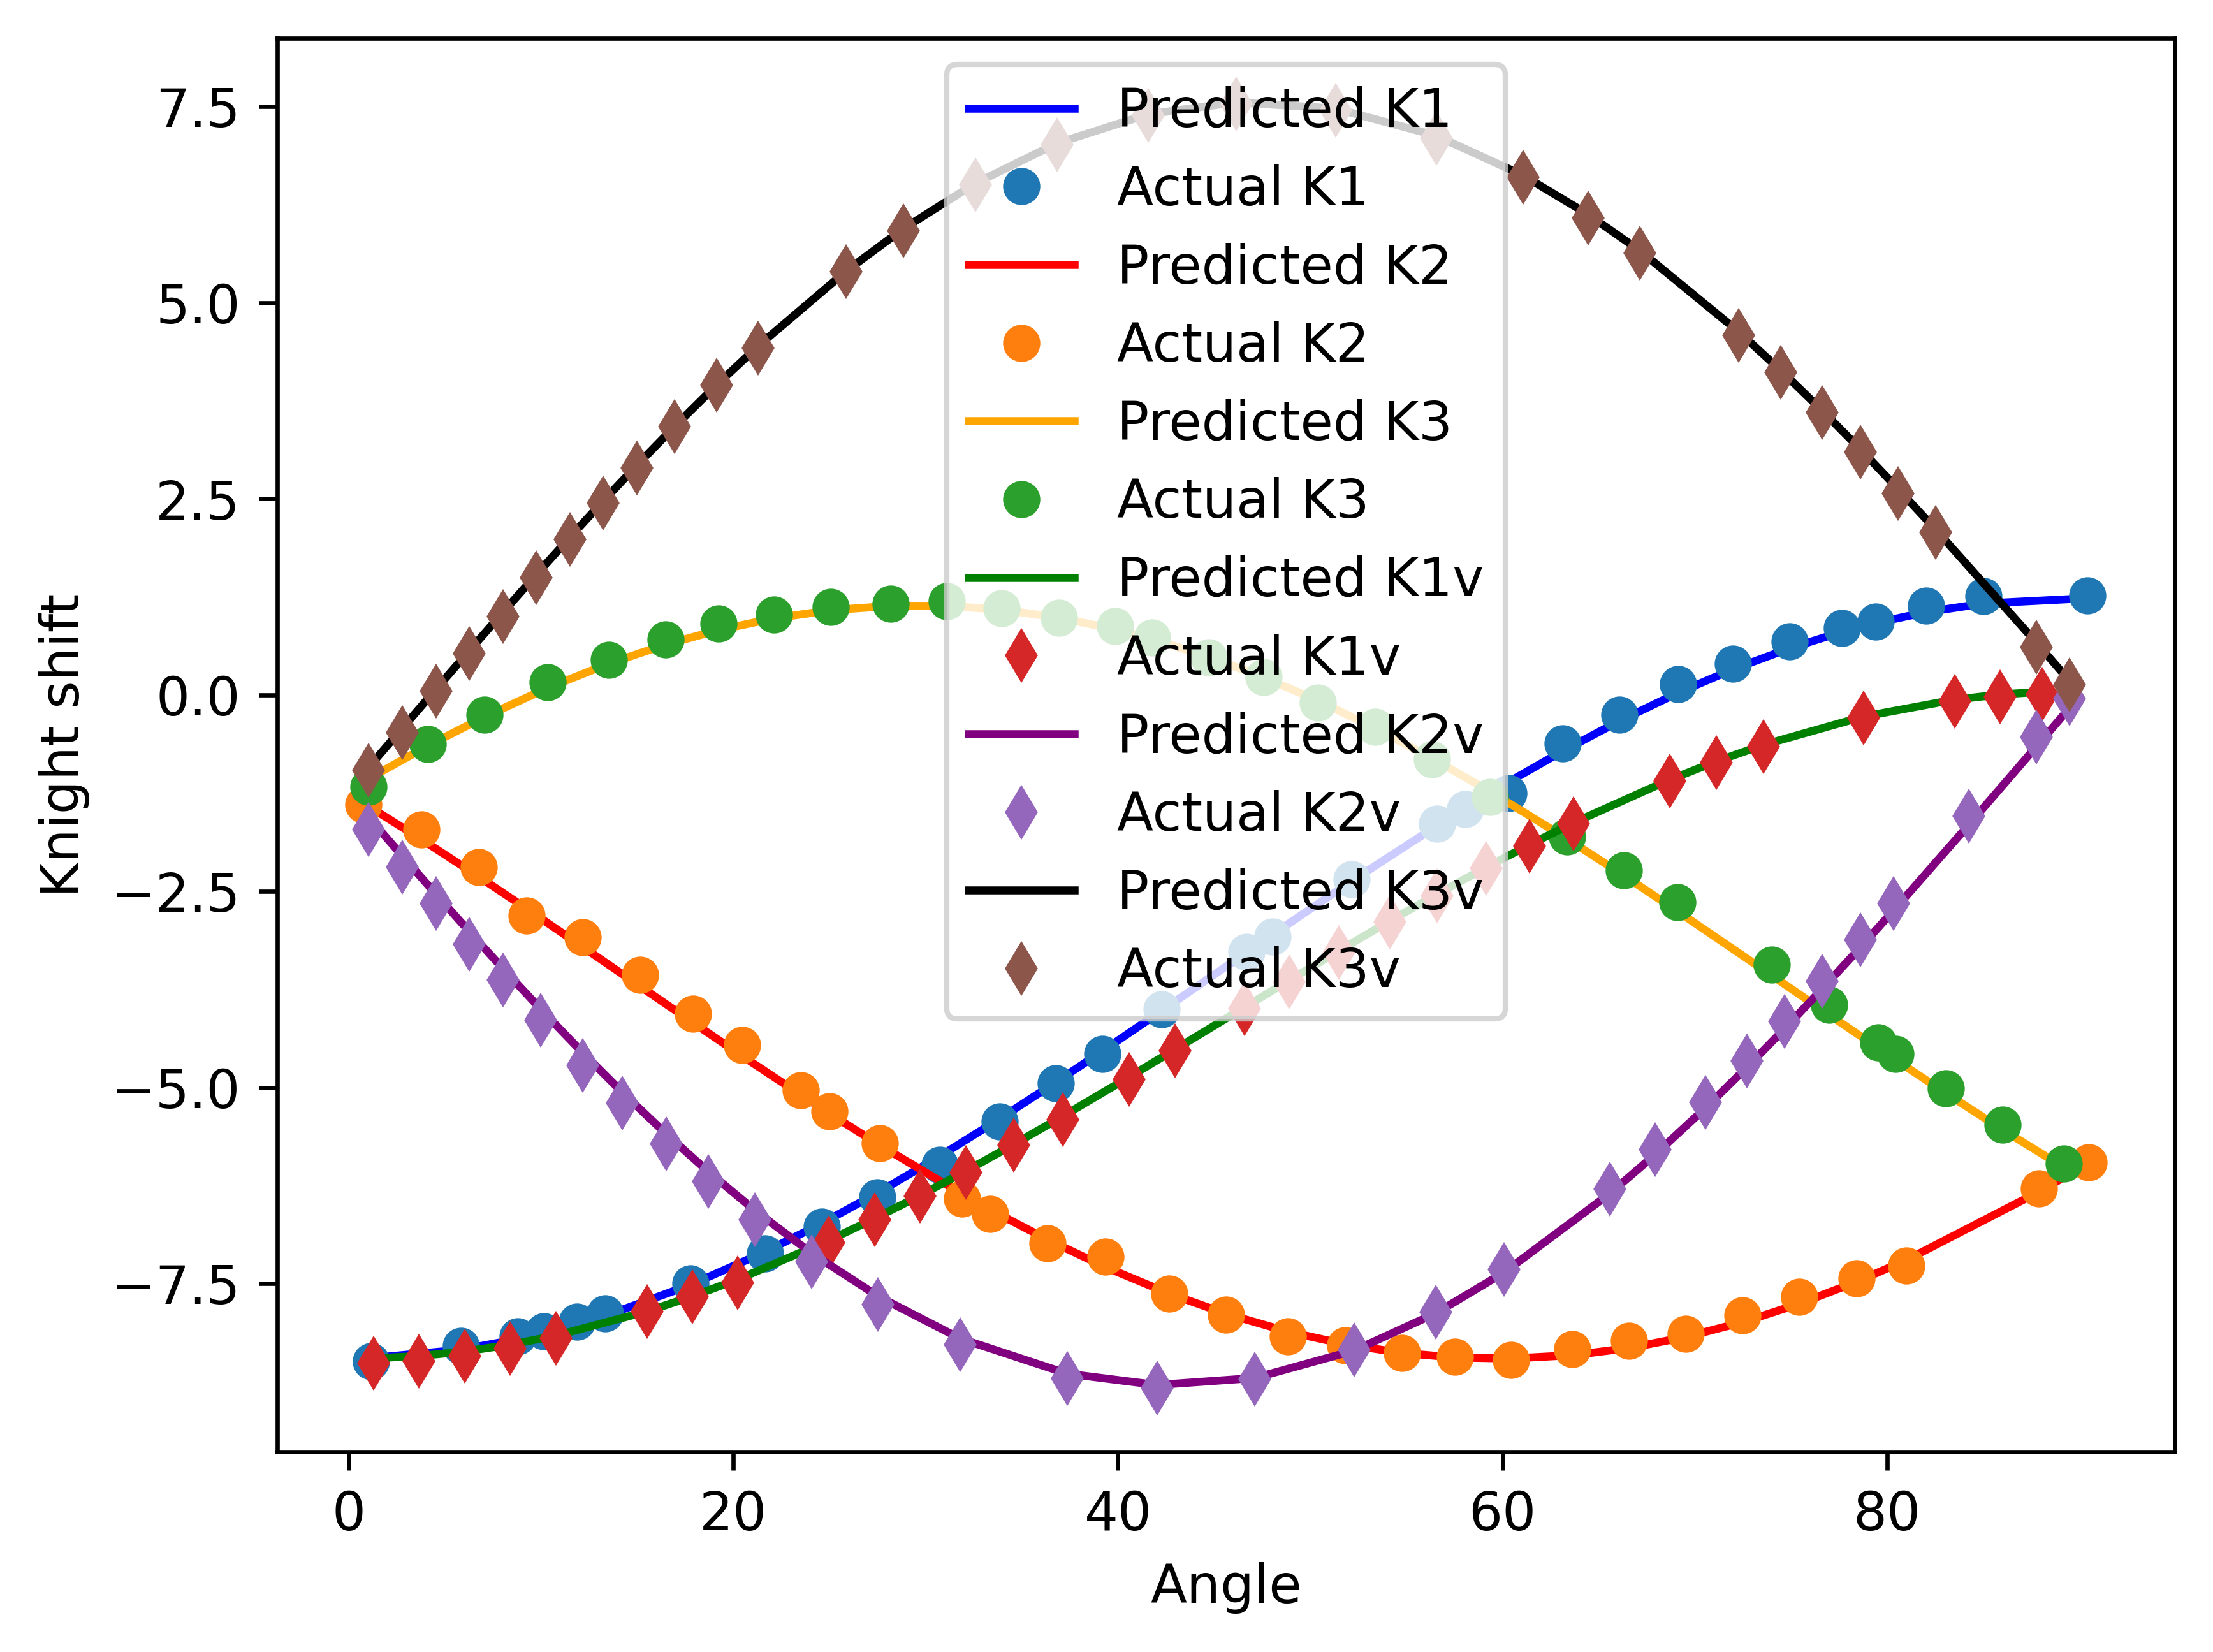

[tensor(-8.4558), tensor(1.1665), tensor(0.0226), tensor(9.3910), tensor(-0.0018), tensor(0.0603), tensor(0.2220), tensor(24.3584), tensor(89.9047), tensor(0.)]


In [13]:
# 最適化後のパラメータを取得し、Tensorに変換
params = [torch.tensor(val) for val in [k1.item(), k2.item(), k3.item(), k4.item(), k5.item(), k6.item(), t1.item(), p1.item(), t2.item(), p2.item()]]

outputs = [model(x, k1, k2, k3, k4, k5, k6, t1, p1, t2, p2) for x in [x1, x2, x3, x4, x5, x6]]

y_p1 = outputs[0]['shift1'][0]
y_p2 = outputs[1]['shift1'][1]
y_p3 = outputs[2]['shift1'][2]
y_p4 = outputs[3]['shift2'][0]
y_p5 = outputs[4]['shift2'][1]
y_p6 = outputs[5]['shift2'][2]

# 結果の可視化
fig = plt.figure(dpi=600)

plt.plot(x1.detach().numpy(), y_p1.detach().numpy(), label="Predicted K1", color = "blue") 
plt.plot(x1.detach().numpy(), y1.numpy(), 'o', label="Actual K1")

plt.plot(x2.detach().numpy(), y_p2.detach().numpy(), label="Predicted K2", color = "red") 
plt.plot(x2.detach().numpy(), y2.numpy(), 'o', label="Actual K2")

plt.plot(x3.detach().numpy(), y_p3.detach().numpy(), label="Predicted K3", color = "orange") 
plt.plot(x3.detach().numpy(), y3.numpy(), 'o', label="Actual K3")

plt.plot(x4.detach().numpy(), y_p4.detach().numpy(), label="Predicted K1v", color = "green") 
plt.plot(x4.detach().numpy(), y4.numpy(), 'd', label="Actual K1v")

plt.plot(x5.detach().numpy(), y_p5.detach().numpy(), label="Predicted K2v", color = "purple") 
plt.plot(x5.detach().numpy(), y5.numpy(), 'd', label="Actual K2v")

plt.plot(x6.detach().numpy(), y_p6.detach().numpy(), label="Predicted K3v", color = "black") 
plt.plot(x6.detach().numpy(), y6.numpy(), 'd', label="Actual K3v")

plt.xlabel("Angle")
plt.ylabel("Knight shift")
plt.legend()
plt.show()
print(params)